In [80]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
import pandas as pd
from keras.callbacks import ModelCheckpoint
np.random.seed(1) # set a seed so that the results are consistent
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.constraints import maxnorm
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

# Load Data

In [81]:
data=pd.read_csv('vector_facies.csv')
#training_data = shuffle(training_data)
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [82]:
data['Well Name'].dtypes,data['Formation'].dtypes

(dtype('O'), dtype('O'))

In [83]:
# So in order to save some memory we will change object to category datatype
#A string variable consisting of only a few different values 
#Converting such a string variable to a categorical variable will save some memory
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')
data['Well Name'].unique()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Facies     4149 non-null   int64   
 1   Formation  4149 non-null   category
 2   Well Name  4149 non-null   category
 3   Depth      4149 non-null   float64 
 4   GR         4149 non-null   float64 
 5   ILD_log10  4149 non-null   float64 
 6   DeltaPHI   4149 non-null   float64 
 7   PHIND      4149 non-null   float64 
 8   PE         3232 non-null   float64 
 9   NM_M       4149 non-null   int64   
 10  RELPOS     4149 non-null   float64 
dtypes: category(2), float64(7), int64(2)
memory usage: 301.1 KB


In [84]:
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [85]:
#checking for null values if have any drop them
data.isna().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
            ... 
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
Length: 11, dtype: int64

# Data Preprocessing

In [86]:
#dropping nuull values in 'PE' columns (All wells doesn't have  photoelectric effect)
PE_filter = data['PE'].notnull().values
data = data[PE_filter]
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [87]:
#there are 9 diff facies so assign them with different colors and labels
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_dict = {}
for i, label in enumerate(facies_labels):
    facies_color_dict[label] = facies_colors[i]
facies_color_dict

{'SS': '#F4D03F',
 'CSiS': '#F5B041',
 'FSiS': '#DC7633',
 'SiSh': '#6E2C00',
 'MS': '#1B4F72',
 'WS': '#2E86C1',
 'D': '#AED6F1',
 'PS': '#A569BD',
 'BS': '#196F3D'}

In [88]:
#adding facies_labels to thier corresponding facies  in dataframe
data.loc[:,'FaciesLabels'] = data.apply(lambda row: facies_labels[ row['Facies']-1], axis=1)
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


In [89]:
#rough work
logs=data[data['Well Name'] == 'SHRIMPLIN']
s=np.expand_dims(logs['Facies'].values,1)
cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
#logs['Facies'].shape,s.shape
cluster[0].shape

(100,)


# Data Visualization

In [90]:
def log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

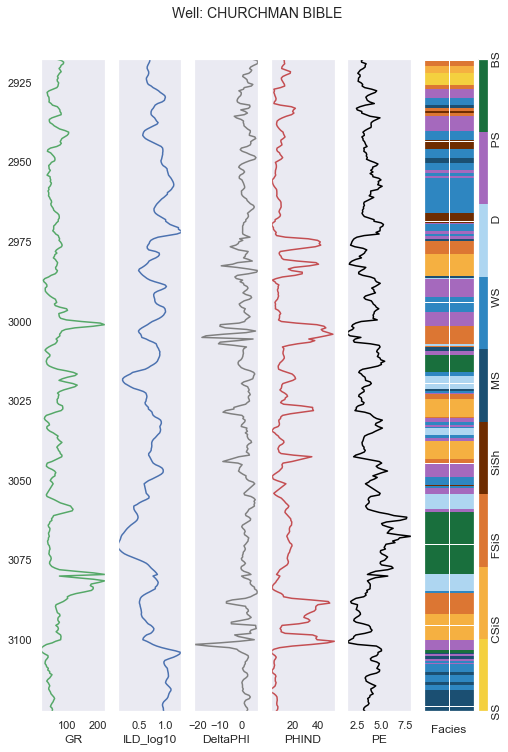

In [91]:
log_plot(data[data['Well Name'] == 'CHURCHMAN BIBLE'], facies_colors)

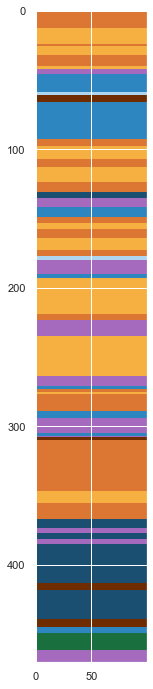

In [92]:
#rough work
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,12))
cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1) 
ax.imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=1,vmax=9)

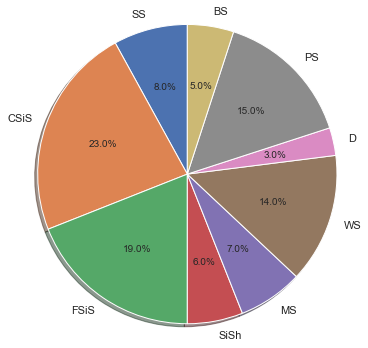

In [93]:
#Nonmarine sandstone --- 'SS'
#Nonmarine coarse siltstone --- 'CSiS'
#Nonmarine fine siltstone --- 'FSiS'
#Marine siltstone and shale --- 'SiSh'
#Mudstone (limestone) --- 'MS'
#Wackestone (limestone) --- 'WS'
#Dolomite -- 'D'
#Packstone-grainstone (limestone) --- 'PS'
#Phylloid-algal bafflestone (limestone) --- 'BS'

count=list(data['Facies'].value_counts().sort_index())
count_label=facies_labels
sizes=[]
for i in range(len(count)):
   perc= round((count[i]/sum(count))*100)
   sizes.append(perc)
    
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, labels=count_label,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

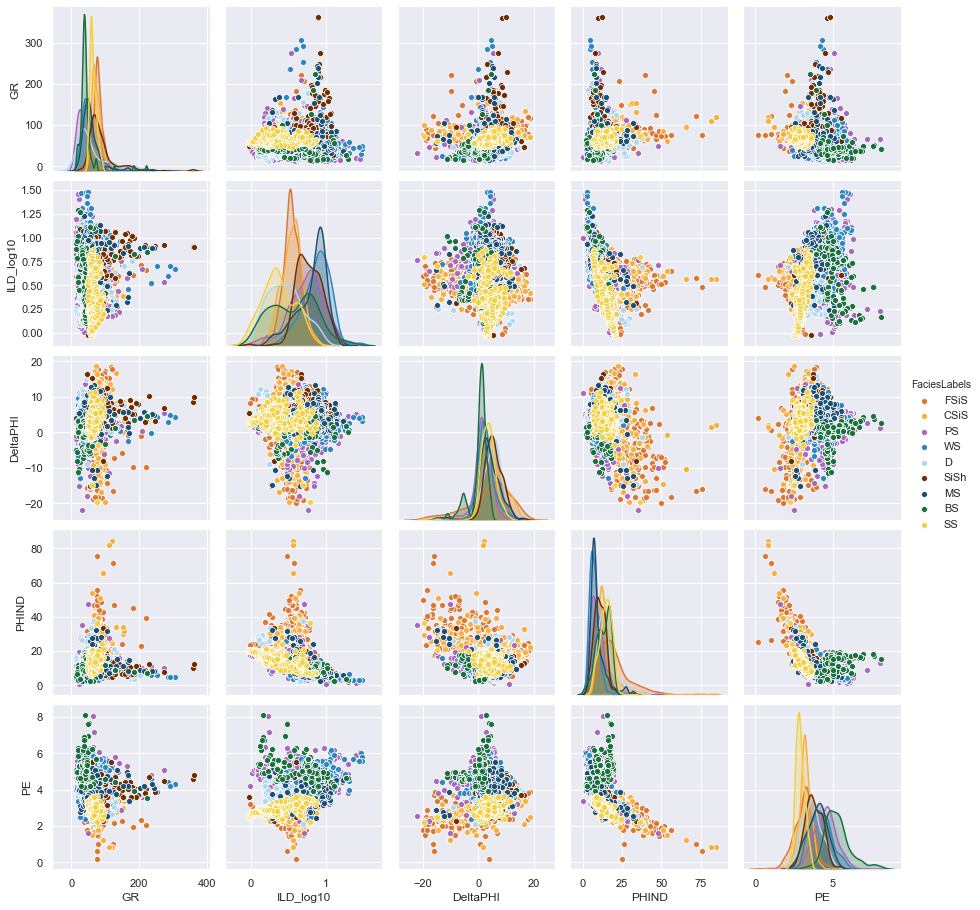

In [94]:
import seaborn as sns
sns.set()
sns.pairplot(data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_dict)

# Data Preparation for Deep Learning Model  

In [95]:
#shuffling data
data=shuffle(data)
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
3962,2,B3 SH,CHURCHMAN BIBLE,3026.0,71.438,0.624000,2.114,12.681,3.123,1,0.429,CSiS
1361,5,C LM,SHANKLE,2996.0,79.980,0.884000,3.000,8.435,3.800,2,0.343,MS
2665,3,B5 SH,CROSS H CATTLE,2766.5,70.610,0.268578,-15.200,35.200,2.453,1,0.038,FSiS
2993,2,B3 SH,NOLAN,2956.5,102.188,0.601000,6.552,13.809,3.486,1,0.923,CSiS
1175,3,B3 SH,SHANKLE,2896.0,85.630,0.386000,7.600,14.515,2.600,1,0.136,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
3680,6,C LM,NEWBY,3025.0,17.320,0.916000,0.400,7.000,4.300,2,0.966,WS
1371,5,C LM,SHANKLE,3001.0,81.370,0.941000,4.300,8.860,4.100,2,0.209,MS
1562,6,B1 LM,LUKE G U,2698.5,57.680,1.095000,2.900,5.350,4.300,2,0.261,WS
235,8,B3 LM,SHRIMPLIN,2910.5,25.400,0.476000,3.500,10.810,5.600,2,0.083,PS


In [96]:
y = data['Facies'].values
x = data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
x.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [97]:
#splitting data to train and test the DL model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [98]:
#Training Data Normalization 
x = x_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS',])
x_train=df
x_train.shape

(2262, 7)

In [99]:
#Testing Data Normalization 
x1 = x_test.values
min_max_scaler1 = preprocessing.MinMaxScaler()
x_scaled1 = min_max_scaler1.fit_transform(x1)
df1 = pd.DataFrame(x_scaled1,columns=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS',])
x_test=df1
x_test.shape

(970, 7)

In [21]:
#Label Encoding of training_data because we have multiclass labels
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_labels = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
encoded_y_train = np_utils.to_categorical(encoded_labels)
encoded_y_train.shape

(2262, 9)

In [22]:
#Label Encoding of training_data because we have multiclass labels
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_label = encoder.transform(y_test)
#convert integers to dummy variables (i.e. one hot encoded)
encoded_y_test = (np_utils.to_categorical(encoded_label))
#==================================================================
#again spiliting the test set (970 elements)
#one will be used for eveluation of model (900 elements)
#another will be used for prediction of model (70 elements)
encoded_y_test1=encoded_y_test[0:900]
x_test1=x_test[0:900]
encoded_y_test2=encoded_y_test[900:]
x_test2=x_test[900:]
len(x_test2),x_test1.shape,x_test.shape

(70, (900, 7), (970, 7))

# Training Deep Learning Model 

In [26]:
def create_model(weight_constraint=0):    
    model = Sequential()
    model.add(Dense(21, input_dim=7, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dense(42, kernel_initializer='he_uniform', activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dense(42, kernel_initializer='he_uniform', activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dense(42, kernel_initializer='he_uniform', activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dense(9, kernel_initializer='he_uniform', activation='softmax'))
    # Compile model
    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
    #model.summary()

In [27]:
#optimizing hyperparameters of DL model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=15)
kfold = KFold(n_splits=3, shuffle=True)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
param_grid = dict( weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(x_train,encoded_y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
2262/2262 [==============================] - 3s 1ms/step - loss: 1.5921 - accuracy: 0.3691
Epoch 2/100
2262/2262 [==============================] - 1s 500us/step - loss: 1.3268 - accuracy: 0.4527
Epoch 3/100
2262/2262 [==============================] - 1s 407us/step - loss: 1.2736 - accuracy: 0.4752
Epoch 4/100
2262/2262 [==============================] - 1s 401us/step - loss: 1.2305 - accuracy: 0.4978
Epoch 5/100
2262/2262 [==============================] - 1s 363us/step - loss: 1.1921 - accuracy: 0.5106
Epoch 6/100
2262/2262 [==============================] - 1s 364us/step - loss: 1.1554 - accuracy: 0.5208
Epoch 7/100
2262/2262 [==============================] - 1s 347us/step - loss: 1.1316 - accuracy: 0.5371
Epoch 8/100
2262/2262 [==============================] - 1s 451us/step - loss: 1.1030 - accuracy: 0.5477
Epoch 9/100
2262/2262 [==============================] - 1s 424us/step - loss: 1.0808 - accuracy: 0.5615
Epoch 10/100
2262/2262 [==============================] -

In [37]:
#use the optimized hyperparameters 
model=create_model(weight_constraint=3)
history=model.fit(x_train,encoded_y_train,validation_data=(x_test1,encoded_y_test1), epochs=100, batch_size=10)

Train on 2262 samples, validate on 900 samples
Epoch 1/100
2262/2262 [==============================] - 2s 880us/step - loss: 1.5454 - accuracy: 0.3802 - val_loss: 1.3968 - val_accuracy: 0.4011
Epoch 2/100
2262/2262 [==============================] - 1s 615us/step - loss: 1.3405 - accuracy: 0.4359 - val_loss: 1.3671 - val_accuracy: 0.4111
Epoch 3/100
2262/2262 [==============================] - 1s 624us/step - loss: 1.2832 - accuracy: 0.4607 - val_loss: 1.2693 - val_accuracy: 0.4678
Epoch 4/100
2262/2262 [==============================] - 1s 649us/step - loss: 1.2139 - accuracy: 0.5004 - val_loss: 1.2508 - val_accuracy: 0.4756
Epoch 5/100
2262/2262 [==============================] - 1s 624us/step - loss: 1.1741 - accuracy: 0.5097 - val_loss: 1.2065 - val_accuracy: 0.4967
Epoch 6/100
2262/2262 [==============================] - 1s 633us/step - loss: 1.1200 - accuracy: 0.5442 - val_loss: 1.1623 - val_accuracy: 0.5144
Epoch 7/100
2262/2262 [==============================] - 1s 654us/step 

In [48]:
print('So we got max accuracy of 0.620690 with: weight_constraint: 3')

So we got max accuracy of 0.620690 with: weight_constraint: 3


In [59]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

### Accuracy Predictions using Confusion Matrix

Text(0.5, 12.5, 'Predicted label')

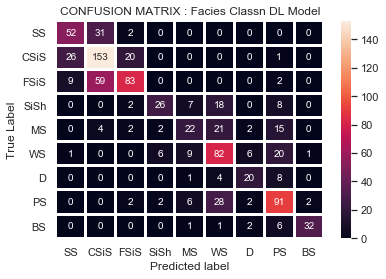

In [40]:
predictions = list(model.predict(x_test1,batch_size=1, verbose=0,steps=None))
len(predictions),len(x_test1)
#====================================================================================
p=[]
for i in range(len(predictions)):
    pred=np.argmax(predictions[i])
    p.append(pred+1)
#====================================================================================
y_test1=y_test[0:900]
conf_dl = confusion_matrix(y_test1, p)
sign=facies_labels
sns.heatmap(conf_dl, annot=True,fmt="d",linewidths=2,xticklabels=sign, yticklabels=sign)
plt.title("CONFUSION MATRIX : Facies Classn DL Model")
plt.ylabel('True Label')
plt.xlabel('Predicted label')

In [41]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


print('Facies classification accuracy = %f' % accuracy(conf_dl))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf_dl, adjacent_facies))

Facies classification accuracy = 0.623333
Adjacent facies classification accuracy = 0.904444


70/70 [==============================] - 0s 271us/step
Val_loss ---> 1.052042
Val_Accuracy ---> 0.542857


Text(0.5, 12.5, 'Predicted label')

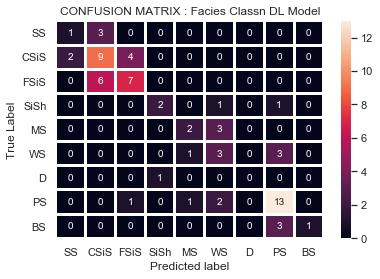

In [60]:
#Prediction of model with new values

prediction = list(model.predict(x_test2,batch_size=1, verbose=0,steps=None))
#====================================================================================
p1=[]
y_test2=y_test[900:]
for i in range(len(prediction)):
    pred=np.argmax(prediction[i])
    p1.append(pred+1)
df= pd.DataFrame([p1,y_test2],index=['Predictions','Actual']).T

#evaluating DL model on another batch of test data
score1=model.evaluate(x_test2,encoded_y_test2,batch_size=10)
Val_loss1,Acc1=score1
print('Val_loss ---> %f' %Val_loss1)
print('Val_Accuracy ---> %f' %Acc1)
df[df['Predictions']==df['Actual']].shape
#============================================================
conf_dl_test = confusion_matrix(y_test2, p1)
sign=facies_labels
sns.heatmap(conf_dl_test, annot=True,fmt="d",linewidths=2,xticklabels=sign, yticklabels=sign)
plt.title("CONFUSION MATRIX : Facies Classn DL Model")
plt.ylabel('True Label')
plt.xlabel('Predicted label')

In [1]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((15*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]);ax[6].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

### Applying the classification model to the new well data

In [67]:
dataset=pd.read_csv('vector_facies.csv')
blind_data = dataset[dataset['Well Name'] == 'CHURCHMAN BIBLE']
y_blind = blind_data['Facies'].values
well_features = blind_data.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
x = well_features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS',])
x_blind=df

x_blind.shape

(404, 7)

In [68]:
encoder = LabelEncoder()
encoder.fit(y_blind)
encoded_labels = encoder.transform(y_blind)
# convert integers to dummy variables (i.e. one hot encoded)
encoded_y_blind = np_utils.to_categorical(encoded_labels)
encoded_y_blind.shape

(404, 9)

404/404 [==============================] - 0s 248us/step
Val_loss ---> 1.543310
Val_Accuracy ---> 0.455446


Text(0.5, 12.5, 'Predicted label')

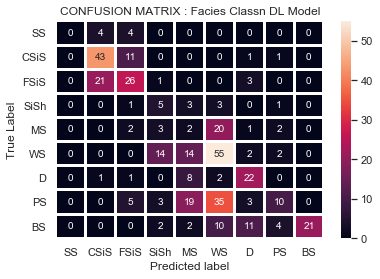

In [72]:
prediction = list(model.predict(x_blind,batch_size=1, verbose=0,steps=None))
#====================================================================================
p1=[]
for i in range(len(prediction)):
    pred=np.argmax(prediction[i])
    p1.append(pred+1)
#evaluating DL model on another batch of test data
score1=model.evaluate(x_blind,encoded_y_blind,batch_size=10)
Val_loss_blind,Acc_blind=score1
print('Val_loss ---> %f' %Val_loss_blind)
print('Val_Accuracy ---> %f' %Acc_blind)

#==========confusion matrix======================
conf_dl_blind = confusion_matrix(y_blind, p1)
sign=facies_labels
sns.heatmap(conf_dl_blind, annot=True,fmt="d",linewidths=2,xticklabels=sign, yticklabels=sign)
plt.title("CONFUSION MATRIX : Facies Classn DL Model")
plt.ylabel('True Label')
plt.xlabel('Predicted label')

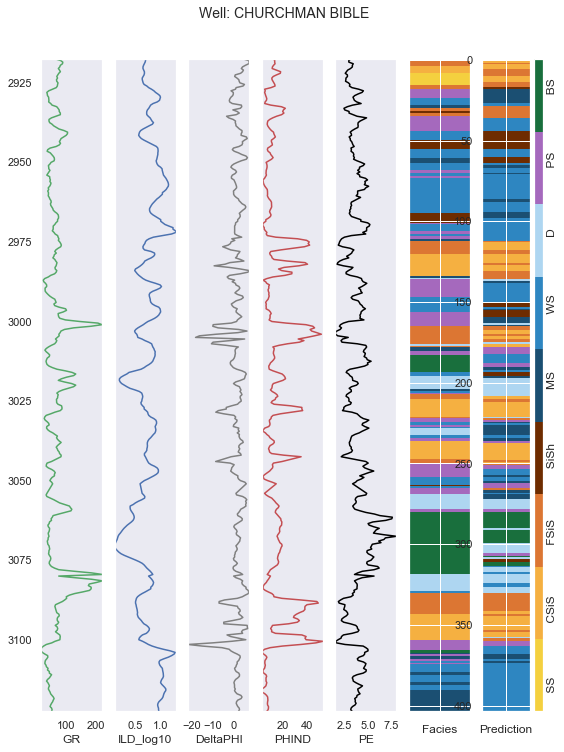

In [118]:
blind_data['Prediction'] = p1
compare_facies_plot(blind_data, 'Prediction', facies_colors)

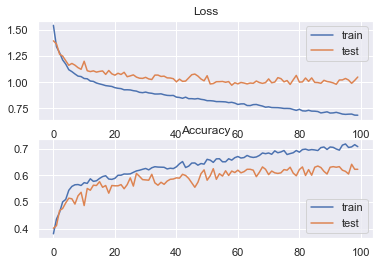

In [119]:
# Plot for loss and accuracy on train and test data
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#### Save and load model

In [45]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test1, encoded_y_test1, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk
Loaded model from disk
accuracy: 62.33%


In [57]:
#testing loaded model
score1 = loaded_model.evaluate(x_test2, encoded_y_test2, verbose=0)
score1

[1.0520422986575535, 0.5428571701049805]